Cosumnes Model 
@author: Andrew

In [117]:
# standard python utilities
import os
from os.path import exists, join, dirname, basename
import sys
import glob
import pandas as pd
import numpy as np

import time
from scipy.stats import gmean, hmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
# import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\andrewc/Box/research_cosumnes/GWFlowModel'

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy/'
if flopy_dir not in sys.path:
    sys.path.append(flopy_dir)
# sys.path
import flopy 

from importlib import reload
# importlib.reload
# reload(flopy)

In [8]:

end_date = '2018-01-2'
# end_date = '2018-01-02'
strt_date = '2018-01-01'

dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = 1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# Steady or transient periods
steady = np.zeros(nper)
steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
nstp = np.ones(nper)

In [9]:
#Maribeth's model parameters, had to switch nrow and ncol due to her issue in xul, yul
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
nlay = 320


# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '

In [10]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

According to Flopy GitHub "Technically you need to create both a SpatialReference object and a ModelGrid object, but in practice the code looks very similar and can easily be implemented in one line."
WGS84 Zone 10N has EPSG: 32610  
Lower left corner of model is   
Zone 10 N  
Easting: 661211.18 m E  
Northing: 4249696.50 m N  
angle is approximate 53 degrees  

## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [184]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Regional/permeameter_upscaling/'

tprogs_id= '' # tprogs data with conditioning data in the model

ptype = 'horizontal'
# ptype = 'vertical'

model_ws = join(loadpth, ptype)
print(model_ws)

C:/WRDAPP/GWFlowModel/Cosumnes/Regional/permeameter_upscaling/horizontal


In [186]:
# simple model to speed up loading but still be able to apply functions
nlay, nrow, ncol = (320, 100,230)
delc, delr= (200, 200)
rotation=52.9



In [187]:


m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
                          version = 'mf2005', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)
xll, yll = 645500.0, 4227700.0
m.modelgrid.set_coord_info(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rotation)


In [155]:
# m.modelgrid.set_coord_info(xoff=xoff, yoff=yoff, proj4='EPSG:32610', angrot=angrot)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')
# mg.write_shapefile(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp', epsg = '32610')


In [15]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
# print(gwfm_dir)

# Find Michigan Bar location
# mb_gpd = sensors[sensors.Sensor_id == "MI_Bar"]
# mb_grid = gpd.sjoin(mb_gpd, grid_p, how = 'left', op = 'intersects')

In [16]:
# Get vertexes of model domain
# ll = mg.get_coords(0, 0) #lower left
# lr = mg.get_coords(nrow*delr, 0) #lower right
# ur = mg.get_coords(nrow*delr, ncol*delc) #upper right
# ul = mg.get_coords(0, ncol*delc) #upper left
ll = mg.get_coords(0, 0) #lower left
lr = mg.get_coords(0, nrow*delr) #lower right
ur = mg.get_coords(ncol*delc, nrow*delr) #upper right
ul = mg.get_coords(ncol*delc, 0) #upper left
print(ll, lr, ur, ul)

# Shapefile of model bounds
from shapely.geometry import Polygon
vertices = np.stack(np.asarray((ll,lr, ur, ul)))
vertices
geoms = Polygon(vertices)

(645500.0, 4227700.0) (629548.3214234954, 4239764.159754906) (657295.8888597784, 4276453.020480867) (673247.567436283, 4264388.860725961)


<>:5: DeprecationWarning: invalid escape sequence '\D'
<>:5: DeprecationWarning: invalid escape sequence '\D'
C:\Users\andrewc\AppData\Local\Temp\ipykernel_13320\3944873049.py:5: DeprecationWarning: invalid escape sequence '\D'
  dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')


<Axes: >

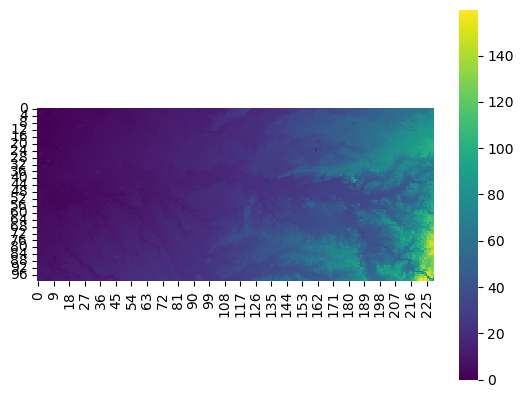

In [17]:
# np.savetxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', dem_data, delimiter = '\t')

# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')

# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_nearest.tsv', delimiter = '\t')

import seaborn as sns
sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

## Alter existing botm for just TPROGS

In [188]:
# rectangular set up of botm from -80 to 80
botm = np.zeros((nlay, nrow, ncol))
for n, elev in enumerate(np.arange(-80,80,0.5)):
    botm[len(botm)-1-n,:,:] = elev


In [189]:
# Set the elevation of the top layer based on the DEM
m.dis.top = 80
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array


DIS PACKAGE DATA VALIDATION:
  7360000 Errors:
    7360000 instances of thin cells (less than checker threshold of 1.0)

  Checks that passed:
    zero or negative thickness
    nan values in top array
    nan values in bottom array



rec.array([('Error', 'DIS',   0,  0,   0, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   0,  0,   1, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS',   0,  0,   2, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ...,
           ('Error', 'DIS', 319, 99, 227, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 319, 99, 228, 0.5, 'thin cells (less than checker threshold of 1.0)'),
           ('Error', 'DIS', 319, 99, 229, 0.5, 'thin cells (less than checker threshold of 1.0)')],
          dtype=[('type', 'O'), ('package', 'O'), ('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('value', '<f8'), ('desc', 'O')])

## ibound

In [190]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
strt[:,:,:] = m.dis.top[:,:]



In [191]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt)

In [192]:
bas.check()



BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Read in TPROGS data

In [23]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/Archive/TPROGS_realizations/'
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/TPROGS_realizations/'
# tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/New_realizations/'

# # get all file names
# tprogs_files = glob.glob(tprogs_dir+'*')


In [24]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final' + tprogs_id+'/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')
# tprogs_files

In [25]:
gel_dir = gwfm_dir+'/UPW_data'
if 'ZonePropertiesInitial.csv' in os.listdir(model_ws):
    params = pd.read_csv(model_ws+'/ZonePropertiesInitial.csv',index_col='Zone')
else:
    params = pd.read_csv(gel_dir+'/ZonePropertiesInitial.csv',index_col='Zone')
    params.to_csv(model_ws+'/ZonePropertiesInitial.csv')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

In [26]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

# reload(tc)

In [48]:
t=0
tprogs_info = [80, -80, 320]

tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, m.dis.top.array, tprogs_info)
K, Sy, Ss, porosity = tc.int_to_param(masked_tprogs, params, porosity=True)


PermissionError: [Errno 13] Permission denied

In [49]:
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, m.dis.top.array, tprogs_info)
K, Sy, Ss, porosity = tc.int_to_param(masked_tprogs, params, porosity=True)


## LPF/UPW package

In [51]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [52]:
# # take of 2 for the bottom layers and 1 for the unsat zone layer up top
# # for tprogs arrays 0 is the bottom of the model, so flipping on z will fix
hk = np.flip(K,axis=0)
#need to set anisotropy for TPROGs, may not matter for this
vka = np.flip(K,axis=0)
sy = np.flip(Sy,axis=0)
ss = np.flip(Ss,axis=0)


The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had
Kh = 1 to 1.8 x10^-5 m/s
Kv = 1 to 1.8 x10^-7 m/s
Sy = 0.15 to 0.2
Ss = 1e-4 to 1e-3 m^-1

In [54]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
laytyp = np.zeros(nlay)
# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
# upw = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, ss=ss,
#             laytyp=laytyp, ipakcb=55)

lpf = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = vka, sy=sy, ss=ss,
                               laytyp=laytyp, laywet = laywet, ipakcb=55)

In [56]:
# lpf.write_file()

## CHD Package Time variant head
May need to remove Mehrten formation and leave Laguna as bottom to avoid having very low conductivity layer causing water mounding, but still need Laguna formation to balance out the layer in the bottom layer with TPROGs.

In [193]:
chd = flopy.modflow.ModflowChd(model=m,ipakcb=55)

In [194]:
# model top constant head boundary
chd_df_all = grid_p.copy()
chd_df_all = chd_df_all.drop(['geometry','node'],axis=1)
chd_df_all.row -= 1
chd_df_all.column -=1





In [207]:
# a gradient of 0.001 converged but still had large water budget error
if ptype=='horizontal':
    chd_right = chd_df_all[chd_df_all.column ==ncol-1].copy()
    chd_right = pd.concat((chd_right.row.repeat(nlay), chd_right.column.repeat(nlay)), axis=1)
    chd_right['layer'] = np.tile(np.arange(0,nlay), nrow)
    chd_right['head'] = 80

    chd_left = chd_df_all[chd_df_all.column ==0].copy()
    chd_left = pd.concat((chd_left.row.repeat(nlay), chd_left.column.repeat(nlay)), axis=1)
    chd_left['layer'] = np.tile(np.arange(0,nlay), nrow)
#     chd_left['head'] = 80 - 0.001*(delr*ncol) # 46 m head drop is a little extreme
    chd_left['head'] = 80 - 0.0001*(delr*ncol) # trying 1/10 smaller for error # 4.6 m head drop is more reasonable

    chd_df = pd.concat((chd_right, chd_left))


In [196]:
# applied a gradient of only 0.01 to avoid excess pushing of flow as suggested by Graham
if ptype=='vertical':
    chd_df = chd_df_all.copy()
    chd_df['layer'] = 0
    chd_df['head'] = m.dis.top.array[chd_df.row, chd_df.column]
    # model bottom constant head boundary

    chd_bot = chd_df.copy()
    chd_bot.layer = m.dis.nlay-1
    # if head at bottom = -80 m then there is a head gradient of 1
    chd_bot['head'] = m.dis.botm.array[chd_bot.layer[0], chd_bot.row, chd_bot.column]
    # for a head gradient of 0.1 the head at the bottom must be 64m
    # h = 80 - 0.1*160
    h = 80 - 0.01*160 # check to see impact of lower gradient
    chd_bot['head'] = h

    chd_df = pd.concat((chd_df, chd_bot))


In [208]:
# prep format for MF input: layer, row, column, shead, ehead
chd_arr = chd_df.loc[:,['layer','row','column','head','head']].values
chd.stress_period_data =  {0: chd_arr}
chd.check()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



In [210]:
chd.write_file()

## Output Control

In [35]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-pd.to_datetime(strt_date)).days

for j in month_intervals:
    spd[j,0] = ['save head', 'save budget','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

## Newton Solver

In [213]:
max_outer = 200
max_inner = 100

solver = flopy.modflow.ModflowPcgn(m, iter_mo = max_outer, iter_mi=max_inner, close_r=1e-05, close_h=1e-06, ipunit=28) 
#                                 relax = 0.99, ifill=1)
#                                adamp=1, damp=0.7, damp_lb=0.1, rate_d=0.01)


In [214]:
solver.write_file()

In [39]:
m.get_package_list()
# m.remove_package('DATA')
# m.remove_package('LAK')
# m.remove_package('WEL')
# m.remove_package('RCH')
# m.remove_package('NWT')

['DIS', 'BAS6', 'LPF', 'CHD', 'OC', 'PCGN']

In [40]:

# m.check()
# lak.check()
# upw.check()

## Write the input files

In [73]:
# loadpth = 'C:/WRDAPP/GWFlowModel/Cosumnes_Blodgett_10yr/'
# model_ws = loadpth+'WEL_SFR_RCH_layercake'
# m = flopy.modflow.Modflow.load('MF.nam',model_ws = model_ws)

In [41]:
m.model_ws

'C:/WRDAPP/GWFlowModel/Cosumnes/Regional/permeameter_upscaling'

In [42]:
# Writing the MODFLOW data files
m.write_input()


C:\Users\andrewc\Anaconda3\envs\geo_env\Lib\site-packages\flopy\utils\util_array.py:2663: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  else output_fmt.format(d)
C:\Users\andrewc\Anaconda3\envs\geo_env\Lib\site-packages\flopy\utils\util_array.py:2659: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  output_fmt.format(d) + "\n"


# Flux review

## Vertical

In [123]:
wb_v = pd.read_csv(join(loadpth,'vertical','flow_budget.txt'), delimiter=r'\s+')
#     wb = pd.read_csv(flow_name, delimiter=r'\s+')


$ Q = -kiA = -k\frac{h1-h2}{L}A $

In [228]:
avg_flux = (wb_v['CHD_IN']+wb_v['CHD_OUT'])/2

h1 = 80
h2 = 80 - 0.01*160 # check to see impact of lower gradient
l = 160
# calculate darcian velocity by dividing by area of model in the horizontal plane
avg_q = avg_flux/(delc*nrow*delr*ncol)

# permeameter calculated vertical conductivity
p_vka = avg_q*l/(h1-h2)
p_vka

0    1.023383
dtype: float64

In [121]:
hmean(vka, axis=(0,1,2)) # if harmonic is applied directly

0.9516582291937099

## Horizontal
Model took almost 1 hr with 1E-4 residual close and 1E-5 head close but still had 7.9% error -> it looks like the lower head value was still at 34m somehow which probably caused the extreme error

In [220]:
wb_h = pd.read_csv(join(loadpth,'horizontal','flow_budget.txt'), delimiter=r'\s+')


In [221]:
wb_h

,DATE_START,PER,STP,DELT,SIMTIME,STORAGE_IN,STORAGE_OUT,CHD_IN,CHD_OUT,IN_OUT,PERCENT_ERROR
0,NaN,1,1,1.0,1.0,0.0,0.0,12465.45268,12572.15159,106.69891,0.852309


In [235]:
avg_flux = (wb_h['CHD_IN']+wb_h['CHD_OUT'])/2

h1 = 80
h2 = 80 - 0.0001*(delr*ncol)
l = delr*ncol
# calculate darcian velocity by dividing by area of model in the vertical plane
avg_q = avg_flux/(delc*nrow*160)

# permeameter calculated vertical conductivity
p_hk = avg_q*l/(h1-h2)

In [236]:
p_hk

0    39.121257
dtype: float64

In [227]:
np.nanmean(hk)

49.889428505217424

In [232]:
np.unique(hk)

masked_array(data=[0.5616, 21.6, 129.6, 345.6],
             mask=[False, False, False, False],
       fill_value=1e+20)

In [243]:
p_vka.values[0]

1.0233827228260908

In [245]:
k_out = [['HK', np.nanmean(hk), p_hk.values[0]], 
 ['VKA', hmean(vka, axis=(0,1,2)), p_vka.values[0]]]
df_out = pd.DataFrame(k_out, columns=['name', 'calculated', 'permeameter'])
df_out.to_csv(join(gwfm_dir, 'UPW_data', 'permeameter_regional.csv'))